### In this notebook, we will see how we can use autoencoder as a classifier with fashion MNIST dataset.
- Fashion MNIST dataset is a 28x28 grayscale images of 70,000 fashion products from 10 categories, with 7,000 images per category. The training set has 60,000 images, and the test set has 10,000 images.
- It is a replacement for the original MNIST handwritten digits dataset for producing better results. The Fashion MNIST dataset consists of 10 different classes of fashion accessories like shirts, trousers, sandals, etc 
- The image dimensions, training and test splits are similar to the original MNIST dataset. 
- The dataset is freely available on this URL and can be loaded using both tensorflow and keras as a framework without having to download it on your computer.

So, what we want to do is built a convolutional autoencoder and use the encoder part of it combined with fully connected layers to recognize a new sample from the test set correctly.

In [1]:
# Loading the dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gzip

from sklearn.model_selection import train_test_split

from keras.models import Model, Sequential
from keras.optimizers import RMSprop, Adam, SGD, Adadelta
from keras.layers import Conv2D, Input, Dense, Flatten,Dropout, merge, Reshape, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras import backend as k
from keras.utils import to_categorical

/home/chhayc/anaconda3/envs/chhayc/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


The way we read the data is as follows:
- We open and read the gzip file as bytestream
- We then convert the string stored in buffer using np.frombuffer() to numpy array of type float32.
- Data is then reshaped into a 3-dimentional array.

### Loading the data

In [2]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buffer = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buffer, dtype = np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

In [3]:
train_data = extract_data('train-images-idx3-ubyte.gz' ,60000)
test_data = extract_data('t10k-images-idx3-ubyte.gz',10000)

The way we read the labels is the same as we read the data:
- We define a function which opens the label file as a bytestream using bytestream.read() to which you pass the label dimension as 1 and the total number of images.
- We then convert the string stored in the buffer to a numpy array of type int64.
- We do not need to reshape the array since the variable labels will return a column vector of dimension 60,000 x 1.

In [4]:
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buffer = bytestream.read(1 * num_images)
        labels = np.frombuffer(buffer, dtype = np.uint8).astype(np.uint64)
        return labels

In [5]:
train_labels = extract_labels('train-labels-idx1-ubyte.gz', 60000)
test_labels = extract_labels('t10k-labels-idx1-ubyte.gz',10000)

In [6]:
train_labels[:10]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint64)

### Data Exploration

In [7]:
# To see the dimension of images in the training set
print("Training set (images) shape: {shape}", format(train_data.shape))

# To see the dimension of images in the test set
print("Test set (image) shape: {shape}", format(test_data.shape))

Training set (images) shape: {shape} (60000, 28, 28)
Test set (image) shape: {shape} (10000, 28, 28)


We don't need training an testing labels for convolutional encoder as the task at hand is to reconstruct the images. However, we do need them for classification task and for data exploration purposes.

In [8]:
# we will now create a dictionary of class names with their corresponding class labels:
label_dict = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I',
    9: 'J' 
}

Let us now look at few of the images in the dataset

Text(0.5,1,'(Label: E)')

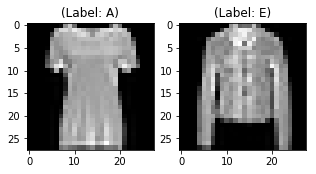

In [9]:
plt.figure(figsize=[5,5])

# display an image from the training data
plt.subplot(121)
curr_img = np.reshape(train_data[10], (28,28))
curr_label = train_labels[10]
plt.imshow(curr_img, cmap = 'gray')
plt.title("(Label: " + str(label_dict[curr_label]) + ")")

# display an image from the testing data
plt.subplot(122)
curr_img = np.reshape(test_data[10], (28,28))
curr_label = test_labels[10]
plt.imshow(curr_img, cmap= 'gray')
plt.title("(Label: " + str(label_dict[curr_label])+ ")")

These images are assigned class labels as 0 or A / 4 or E. This means all the alphabets having class of E will have the class label of 4.


### Data Preprocessing

We need to do the preprocessing of the data before feeding it to the model as our images are gray scale images having pixel values ranging from 0 to 255 with dimension of 28 * 28.
So we will convert each 28 * 28 image into a matrix of size 28 * 28 * 1 which can be fed to the network.

In [10]:
train_data = train_data.reshape(-1, 28, 28, 1)
test_data = test_data.reshape(-1, 28, 28, 1)
print("Train data shape", train_data.shape)
print("Test data shape", test_data.shape)

Train data shape (60000, 28, 28, 1)
Test data shape (10000, 28, 28, 1)


In [11]:
# checking the datatype of the numpy arrays
train_data.dtype, test_data.dtype

(dtype('float32'), dtype('float32'))

In [12]:
# rescaling the pixel values to 0-1 scale by rescaling with maximum pixel value of the training and testing data
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [13]:
# verify the maximum value of the training and the testing data
np.max(train_data), np.max(test_data)

(1.0, 1.0)

### Splitting the data into train and validation sets

In [14]:
# We will now split the data into 80% training and 20% validation. This will help us to reduce the chances of overfitting
# as you would be validating the model on the data it has not seen in the training.
X_train, X_val, y_train, y_val = train_test_split(train_data, train_data, test_size = 0.2, random_state = 12345)

In [15]:
X_train.shape

(48000, 28, 28, 1)

In [16]:
X_val.shape

(12000, 28, 28, 1)

In [22]:
# Now the data is ready to be fed to the network. 
batch_size = 128
epochs = 200
channel = 1
x, y = 28, 28
input_image = Input(shape = (x, y, channel))
num_classes = 10

We will build encoder and a decoder using convolutional layers.
Batch Normalization layer is used

In [34]:
# Building an encoder
def encoder(input_image):
    # input dimension - 28 * 28 * 1
    conv1 = Conv2D(32, (3,3), activation = 'relu', padding = 'same') (input_image)  # 28 *28 * 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3,3), activation = 'relu', padding = 'same') (conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size = (2,2))(conv1)  # 14 * 14 * 32
    conv2 = Conv2D(64, (3,3), activation = 'relu', padding = 'same') (pool1) # 14 * 14 * 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3,3), activation = 'relu', padding = 'same') (conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size = (2,2)) (conv2) # 7 * 7 * 64
    conv3 = Conv2D(128, (3,3), activation = 'relu', padding = 'same') (pool2) # 7 * 7 * 128
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3,3), activation = 'relu', padding = 'same') (conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256,(3,3), activation = 'relu', padding = 'same') (conv3) # 7 * 7 * 256
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3,3), activation = 'relu', padding = 'same') (conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

In [37]:
# Building a decoder
def decoder(conv4):
    conv5 = Conv2D(128, (3,3), activation = 'relu', padding = 'same') (conv4) # 7 * 7 * 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3,3), activation= 'relu', padding ='same') (conv5)# 7 * 7 * 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3,3), activation= 'relu', padding = 'same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2)) (conv6)  # 14 * 14 * 64
    conv7 = Conv2D(32, (3,3), activation = 'relu', padding = 'same') (up1)# 14 * 14 * 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3,3), activation ='relu', padding = 'same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 * 28 * 32
    decoded = Conv2D(1,(3, 3),  activation = 'sigmoid', padding ='same') (up2) # 28 * 28 * 1
    return decoded

In [39]:
# Compiling the model using RMSProp optimizer (helps in reducing overfitting by 
# changing learning rate while the model is training) and specifying the loss as mean squared loss
autoencoder = Model(input_image, decoder(encoder(input_image)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [40]:
# Let us see the autoencoder summary
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_49 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_50 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 14, 14, 64)        18496     
__________

### Training the model 

In [41]:
# we will now train the autoencoder for 200 epochs using keras fit function
# We are going to save the history to plot accuracy and loss curves to help in analyzing the model performance.
autoencoder_train = autoencoder.fit(X_train, y_train, batch_size = batch_size, epochs= epochs,
                                   verbose =1, validation_data = (X_val, y_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 12s 257us/step - loss: 0.0270 - val_loss: 0.0203
Epoch 2/200
48000/48000 [==============================] - 10s 200us/step - loss: 0.0112 - val_loss: 0.0119
Epoch 3/200
48000/48000 [==============================] - 10s 201us/step - loss: 0.0096 - val_loss: 0.0110
Epoch 4/200
48000/48000 [==============================] - 10s 201us/step - loss: 0.0080 - val_loss: 0.0089
Epoch 5/200
48000/48000 [==============================] - 10s 200us/step - loss: 0.0070 - val_loss: 0.0062
Epoch 6/200
48000/48000 [==============================] - 10s 201us/step - loss: 0.0060 - val_loss: 0.0064
Epoch 7/200
48000/48000 [==============================] - 10s 203us/step - loss: 0.0052 - val_loss: 0.0076
Epoch 8/200
48000/48000 [==============================] - 10s 202us/step - loss: 0.0051 - val_loss: 0.0061
Epoch 9/200
48000/48000 [==============================] - 10s 203us/step - loss: 0.00

Epoch 76/200
48000/48000 [==============================] - 10s 204us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 77/200
48000/48000 [==============================] - 10s 204us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 78/200
48000/48000 [==============================] - 10s 204us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 79/200
48000/48000 [==============================] - 10s 203us/step - loss: 0.0012 - val_loss: 0.0017
Epoch 80/200
48000/48000 [==============================] - 10s 203us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 81/200
48000/48000 [==============================] - 10s 203us/step - loss: 0.0012 - val_loss: 0.0015
Epoch 82/200
48000/48000 [==============================] - 10s 203us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 83/200
48000/48000 [==============================] - 10s 203us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 84/200
48000/48000 [==============================] - 10s 203us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 85/200
48000/

48000/48000 [==============================] - 10s 203us/step - loss: 9.0550e-04 - val_loss: 0.0011
Epoch 150/200
48000/48000 [==============================] - 10s 203us/step - loss: 9.1026e-04 - val_loss: 0.0011
Epoch 151/200
48000/48000 [==============================] - 10s 204us/step - loss: 9.0270e-04 - val_loss: 0.0011
Epoch 152/200
48000/48000 [==============================] - 10s 204us/step - loss: 8.9546e-04 - val_loss: 0.0012
Epoch 153/200
48000/48000 [==============================] - 10s 203us/step - loss: 8.9899e-04 - val_loss: 0.0011
Epoch 154/200
48000/48000 [==============================] - 10s 203us/step - loss: 8.9249e-04 - val_loss: 0.0011
Epoch 155/200
48000/48000 [==============================] - 10s 203us/step - loss: 8.8935e-04 - val_loss: 0.0010
Epoch 156/200
48000/48000 [==============================] - 10s 203us/step - loss: 8.9183e-04 - val_loss: 0.0010
Epoch 157/200
48000/48000 [==============================] - 10s 203us/step - loss: 8.8655e-04 - val_l